In [3]:
#Read pyranoses
import pandas as pd
all_pyranoses = pd.read_csv('/home/douglas/carboanalysis/carboanalysis/pdb/dataframes/puckering/all_pyranoses/all_pyranoses_with_organism_names.csv', sep=';')

In [4]:
#Add conformation

import pandas as pd
from scipy.spatial import cKDTree

# Dados do primeiro DataFrame com as classificações
data = {
    "classificacao": [
        "1,4B", "B1,4", "2,5B", "B2,5", "3,6B", "B3,6",
        "1H2", "2H1", "2H3", "3H2", "3H4", "4H3", "4H5", 
        "5H4", "5H6", "6H5", "6H1", "1H6", 
        "1S3", "3S1", "5S1", "1S5", "6S2", "2S6", 
        "1E", "E1", "2E", "E2", "3E", "E3", "4E", "E4", 
        "5E", "E5", "6E", "E6"
    ],
    "x": [
        240, 60, 120, 300, 0, 180,
        270, 90, 150, 330, 30, 210, 270,
        90, 150, 330, 30, 210,
        210, 30, 90, 270, 330, 150,
        240, 60, 120, 300, 360, 180, 240, 60,
        120, 300, 360, 180
    ],
    "y": [
        90, 90, 90, 90, 90, 90,
        129, 51, 51, 129, 129, 51, 51,
        129, 129, 51, 51, 129,
        88, 92, 92, 88, 88, 92,
        125, 55, 55, 125, 125, 55, 55, 125,
        125, 55, 55, 125
    ]
}

df1 = pd.DataFrame(data)

# Criar uma KDTree para os pontos do primeiro DataFrame
tree = cKDTree(df1[["x", "y"]])

# Encontrar o índice do ponto mais próximo para cada ponto do segundo DataFrame
distances, indices = tree.query(all_pyranoses[["puck.phi_graus", "puck.theta_graus"]])

# Adicionar a classificação correspondente ao segundo DataFrame
all_pyranoses["classificacao"] = df1.loc[indices, "classificacao"].values

all_pyranoses.loc[all_pyranoses['puck.theta_graus'] < 26, 'classificacao'] = '4C1'
all_pyranoses.loc[all_pyranoses['puck.theta_graus'] > 154, 'classificacao'] = '1C4'

print(all_pyranoses)


        Unnamed: 0           sugar   iupac_name  puck.phi_graus  \
0                0  1uhg_NAG_11983    D-GlcpNAc      347.490480   
1                1   6zho_GLC_4663       D-Glcp      124.039117   
2                2   6xql_GLC_2019       D-Glcp      185.981241   
3                3  1hjs_NAG_10514    D-GlcpNAc      356.024056   
4                4   7vin_NAG_4824    D-GlcpNAc      287.453728   
...            ...             ...          ...             ...   
193384      193384   3rtj_NAG_4162  b-D-GlcpNAc       25.360774   
193385      193385  5es4_NAG_49634  b-D-GlcpNAc      350.841768   
193386      193386   2iwg_NAG_6363  b-D-GlcpNAc      312.548706   
193387      193387   1znt_NAG_5033  b-D-GlcpNAc      237.278439   
193388      193388  4mhh_MAN_22350     a-D-Manp      197.430943   

        puck.theta_graus entry_id entry_resolution  is_in_cazy  \
0               6.752308     1UHG              1.9       False   
1               3.192464     6ZHO              1.6       False 

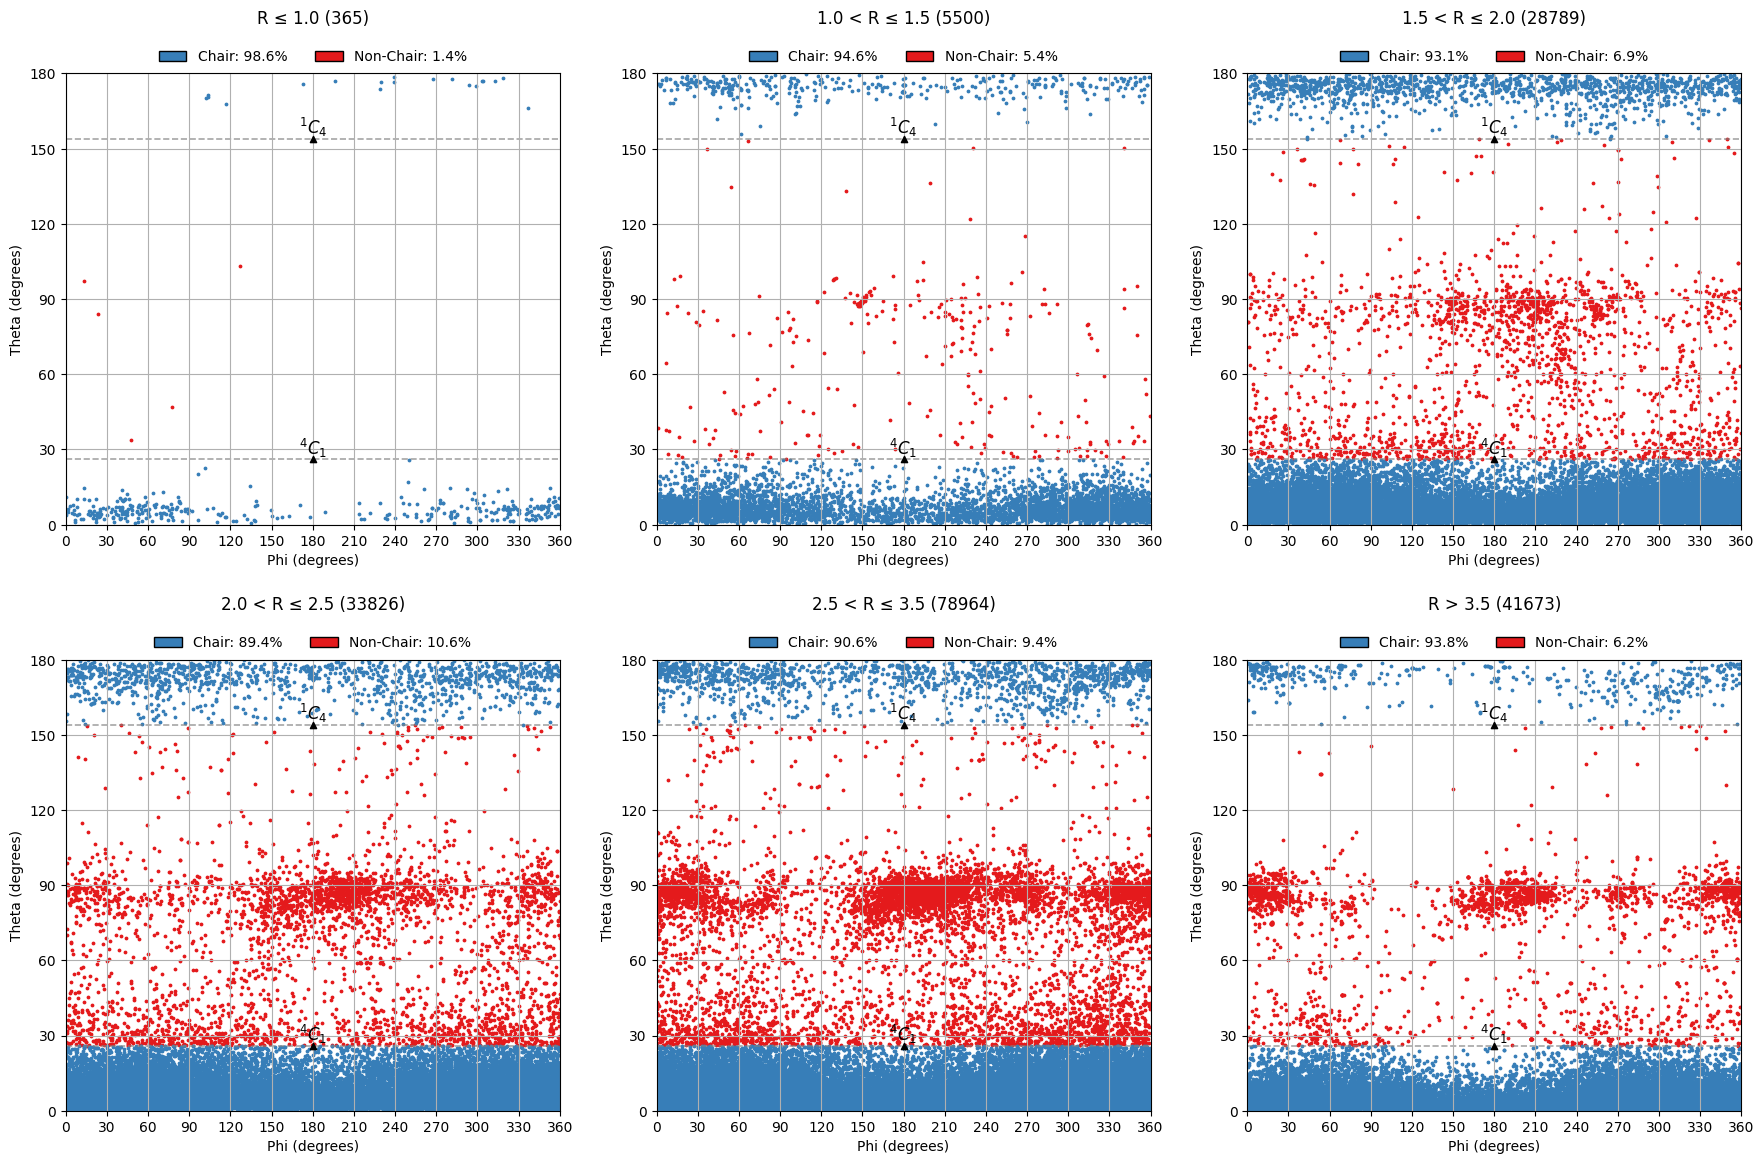

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

df = all_pyranoses
df['entry_resolution'] = pd.to_numeric(df['entry_resolution'], errors='coerce')
df['entry_resolution'] = df['entry_resolution'].fillna(-1)
df = df[df['entry_resolution'] != -1]
df = df.dropna(subset=['entry_resolution'])

# Coordenadas e labels
coordinates = [
    (180, 26, r"$^{4}C_{1}$"),
    (180, 154, r"$^{1}C_{4}$")
]

# Definir os intervalos de resolução
bins = [0, 1.0, 1.5, 2.0, 2.5, 3.5, float('inf')]  # Limites dos intervalos
categories = pd.cut(df['entry_resolution'], bins=bins)  # Categorizar os dados

# Contar os pontos em cada categoria
counts = categories.value_counts(sort=False)  # Sort=False mantém a ordem dos bins

# Criar os labels com os números de pontos
labels = [
    f"R ≤ 1.0 ({counts.iloc[0]})",
    f"1.0 < R ≤ 1.5 ({counts.iloc[1]})",
    f"1.5 < R ≤ 2.0 ({counts.iloc[2]})",
    f"2.0 < R ≤ 2.5 ({counts.iloc[3]})",
    f"2.5 < R ≤ 3.5 ({counts.iloc[4]})",
    f"R > 3.5 ({counts.iloc[5]})"
]

# Adicionar a categoria de intervalo como uma nova coluna
df['resolution_category'] = pd.cut(df['entry_resolution'], bins=bins, labels=labels)

# Criar uma figura com subplots (2 linhas e 3 colunas)
fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # 2 linhas e 3 colunas
axs = axs.flatten()  # Facilita o acesso aos eixos

# Azul padrão para os pontos
default_color = '#377eb8'  # Azul (Chair)
highlight_color = '#e41a1c'  # Vermelho (Non-Chair)

# Loop através das categorias de resolução para criar cada subplot
for i, category in enumerate(labels):
    cat_df = df[df['resolution_category'] == category]  # Filtrar os dados para a categoria atual
    
    # Identificar os pontos que precisam de destaque (y entre 26 e 154)
    highlight_condition = (cat_df['puck.theta_graus'] > 26) & (cat_df['puck.theta_graus'] < 154)
    
    # Pontos destacados (Non-Chair)
    axs[i].scatter(
        cat_df.loc[highlight_condition, 'puck.phi_graus'], 
        cat_df.loc[highlight_condition, 'puck.theta_graus'], 
        color=highlight_color,  # Vermelho
        s=3,  # Tamanho dos pontos
        label='Non-Chair'
    )
    
    # Pontos padrão (Chair)
    axs[i].scatter(
        cat_df.loc[~highlight_condition, 'puck.phi_graus'], 
        cat_df.loc[~highlight_condition, 'puck.theta_graus'], 
        color=default_color,  # Azul
        s=3,  # Tamanho dos pontos
        label='Chair'
    )

    # Cálculo das porcentagens
    total_points = len(cat_df)
    if total_points > 0:
        chair_points = len(cat_df.loc[~highlight_condition])
        non_chair_points = len(cat_df.loc[highlight_condition])
        
        chair_percentage = (chair_points / total_points) * 100
        non_chair_percentage = (non_chair_points / total_points) * 100
    else:
        chair_percentage = non_chair_percentage = 0

    # Adicionar as coordenadas específicas com rótulos
    for x, y, label in coordinates:
        axs[i].axhline(
            y=y, 
            color='gray', 
            linestyle='--', 
            linewidth=1.2, 
            alpha=0.7, 
            zorder=1
        )  # Linha horizontal
        axs[i].scatter(x, y, color='black', s=20, marker='^', zorder=10)  # Ponto marcado
        axs[i].text(
            x, y, 
            label,
            fontsize=12,
            ha='center',
            va='bottom',
            color='black',
            zorder=10
        )

    # Configurações do gráfico
    axs[i].set_xlim([0, 360])  # Limites do eixo x
    axs[i].set_ylim([0, 180])  # Limites do eixo y
    axs[i].set_xlabel('Phi (degrees)')  # Rótulo do eixo x
    axs[i].set_ylabel('Theta (degrees)')  # Rótulo do eixo y

    # Escrever o título com as porcentagens
    axs[i].set_title(
        f'{category}\n\n',
        fontsize=12
    )

    axs[i].grid(True)  # Adicionar grade para melhor visualização

    # Definir os valores dos eixos com intervalo de 30
    axs[i].set_xticks(range(0, 361, 30))  # Eixo x de 0 a 360 com intervalo de 30
    axs[i].set_yticks(range(0, 181, 30))  # Eixo y de 0 a 180 com intervalo de 30

    # Adicionar a legenda dentro do gráfico, entre o título e o gráfico
    legend_elements = [
        Patch(facecolor=default_color, edgecolor='black', label=f'Chair: {chair_percentage:.1f}%'),
        Patch(facecolor=highlight_color, edgecolor='black', label=f'Non-Chair: {non_chair_percentage:.1f}%')
    ]
    axs[i].legend(
        handles=legend_elements,
        loc='upper center',  # Posiciona no topo central
        bbox_to_anchor=(0.5, 1.08),  # Coloca entre o título e o gráfico (ajustado para 1.05)
        fontsize=10,
        frameon=False,  # Remover a caixa de borda
        ncol=2  # Organiza a legenda em duas colunas
    )

# Ajustar o layout para evitar sobreposição
plt.subplots_adjust(hspace=0.3)  # Ajuste o espaçamento entre os subgráficos (hspace controla a altura)
plt.tight_layout(pad=2.0)  # Ajuste de padding para evitar sobreposição
plt.show()


/home/douglas/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


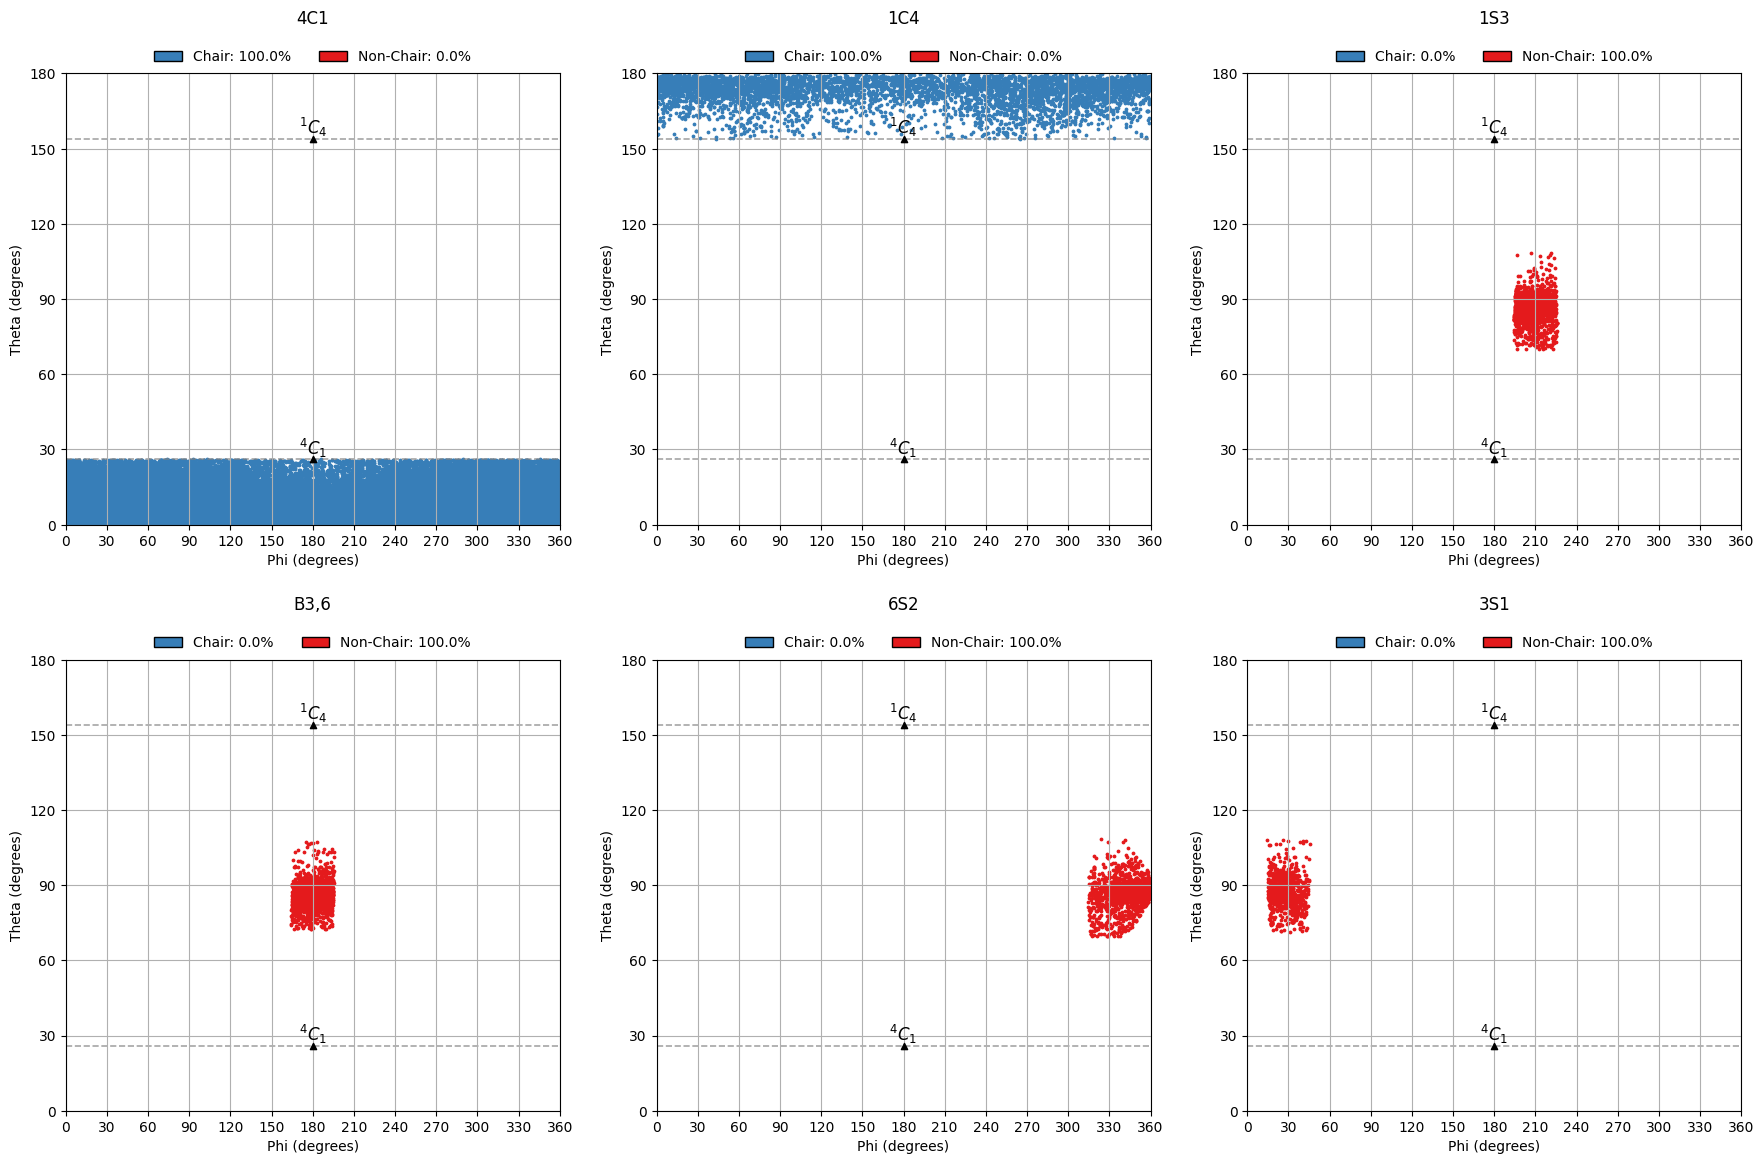

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

df = all_pyranoses

# Identificar as 6 classificações mais frequentes
top_classes = df['classificacao'].value_counts().nlargest(6).index

# Filtrar os dados para conter apenas essas 6 classificações
df = df[df['classificacao'].isin(top_classes)]

# Criar uma figura com subplots (2 linhas e 3 colunas)
fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # 2 linhas e 3 colunas
axs = axs.flatten()  # Facilita o acesso aos eixos

# Azul padrão para os pontos
default_color = '#377eb8'  # Azul (Chair)
highlight_color = '#e41a1c'  # Vermelho (Non-Chair)

# Coordenadas e labels
coordinates = [
    (180, 26, r"$^{4}C_{1}$"),
    (180, 154, r"$^{1}C_{4}$")
]

# Loop através das 6 classificações mais frequentes
for i, classification in enumerate(top_classes):
    class_df = df[df['classificacao'] == classification]  # Filtrar os dados para a classificação atual
    
    # Identificar os pontos que precisam de destaque (y entre 26 e 154)
    highlight_condition = (class_df['puck.theta_graus'] > 26) & (class_df['puck.theta_graus'] < 154)
    
    # Pontos destacados (Non-Chair)
    axs[i].scatter(
        class_df.loc[highlight_condition, 'puck.phi_graus'], 
        class_df.loc[highlight_condition, 'puck.theta_graus'], 
        color=highlight_color,  # Vermelho
        s=3,  # Tamanho dos pontos
        label='Non-Chair'
    )
    
    # Pontos padrão (Chair)
    axs[i].scatter(
        class_df.loc[~highlight_condition, 'puck.phi_graus'], 
        class_df.loc[~highlight_condition, 'puck.theta_graus'], 
        color=default_color,  # Azul
        s=3,  # Tamanho dos pontos
        label='Chair'
    )

    # Cálculo das porcentagens
    total_points = len(class_df)
    if total_points > 0:
        chair_points = len(class_df.loc[~highlight_condition])
        non_chair_points = len(class_df.loc[highlight_condition])
        
        chair_percentage = (chair_points / total_points) * 100
        non_chair_percentage = (non_chair_points / total_points) * 100
    else:
        chair_percentage = non_chair_percentage = 0

    # Adicionar as coordenadas específicas com rótulos
    for x, y, label in coordinates:
        axs[i].axhline(
            y=y, 
            color='gray', 
            linestyle='--', 
            linewidth=1.2, 
            alpha=0.7, 
            zorder=1
        )  # Linha horizontal
        axs[i].scatter(x, y, color='black', s=20, marker='^', zorder=10)  # Ponto marcado
        axs[i].text(
            x, y, 
            label,
            fontsize=12,
            ha='center',
            va='bottom',
            color='black',
            zorder=10
        )

    # Configurações do gráfico
    axs[i].set_xlim([0, 360])  # Limites do eixo x
    axs[i].set_ylim([0, 180])  # Limites do eixo y
    axs[i].set_xlabel('Phi (degrees)')  # Rótulo do eixo x
    axs[i].set_ylabel('Theta (degrees)')  # Rótulo do eixo y

    # Escrever o título com as porcentagens
    axs[i].set_title(
        f'{classification}\n\n',
        fontsize=12
    )

    axs[i].grid(True)  # Adicionar grade para melhor visualização

    # Definir os valores dos eixos com intervalo de 30
    axs[i].set_xticks(range(0, 361, 30))  # Eixo x de 0 a 360 com intervalo de 30
    axs[i].set_yticks(range(0, 181, 30))  # Eixo y de 0 a 180 com intervalo de 30

    # Adicionar a legenda dentro do gráfico, entre o título e o gráfico
    legend_elements = [
        Patch(facecolor=default_color, edgecolor='black', label=f'Chair: {chair_percentage:.1f}%'),
        Patch(facecolor=highlight_color, edgecolor='black', label=f'Non-Chair: {non_chair_percentage:.1f}%')
    ]
    axs[i].legend(
        handles=legend_elements,
        loc='upper center',  # Posiciona no topo central
        bbox_to_anchor=(0.5, 1.08),  # Coloca entre o título e o gráfico (ajustado para 1.05)
        fontsize=10,
        frameon=False,  # Remover a caixa de borda
        ncol=2  # Organiza a legenda em duas colunas
    )

# Ajustar o layout para evitar sobreposição
plt.subplots_adjust(hspace=0.3)  # Ajuste o espaçamento entre os subgráficos (hspace controla a altura)
plt.tight_layout(pad=2.0)  # Ajuste de padding para evitar sobreposição
plt.show()


In [22]:
#Tabela de conformações
import pandas as pd
all_pyranoses = pd.read_csv('/home/douglas/carboanalysis/carboanalysis/pdb/dataframes/puckering/all_pyranoses/all_pyranoses_with_conformations.csv', sep=';')

conformation_table = all_pyranoses['classificacao'].value_counts()

In [36]:
#Merge de Cazy
import pandas as pd

cazy_df = pd.read_csv('/home/douglas/cazy_df_final.csv')
all_pyranoses = pd.read_csv('/home/douglas/carboanalysis/carboanalysis/pdb/dataframes/puckering/all_pyranoses/all_pyranoses_with_conformations.csv', sep=';')

cazy_df = cazy_df[['entry_id', 'Family']]

all_pyranoses = all_pyranoses.merge(cazy_df, how='left', left_on='entry_id', right_on='entry_id')

all_pyranoses = all_pyranoses.drop_duplicates(subset=['sugar'])

all_pyranoses['type_cazy'] = all_pyranoses['Family'].str.replace(r'\d+', '', regex=True)

#Troca pros nomes extensos

cazy_dict = {
    'AA': 'Auxiliary Activities',
    'GH': 'Glycoside Hydrolases',
    'CBM': 'Carbohydrate-Binding Modules',
    'GT': 'Glycosyltransferases',
    'CE': 'Carbohydrate Esterases',
    'PL': 'Polysaccharide Lyases'
}


# Substituir as siglas pelos nomes completos usando o dicionário
all_pyranoses['type_cazy'] = all_pyranoses['type_cazy'].replace(cazy_dict)

# Preencher os valores ausentes em 'type_cazy' com os valores de 'type'
all_pyranoses['type_cazy'] = all_pyranoses['type_cazy'].fillna(all_pyranoses['type'])

# Preencher os valores ausentes em 'type_cazy' com os valores de 'type'
all_pyranoses['type_cazy'] = all_pyranoses['type_cazy'].str.upper()

# Atribuir True para todas as linhas onde 'Familly' não seja missing
all_pyranoses['is_in_cazy'] = all_pyranoses['Family'].notna()

In [37]:
import pandas as pd
# Atribuir True para todas as linhas onde 'Familly' não seja missing
all_pyranoses = all_pyranoses[['sugar',
                                'iupac_name',
                                  'puck.phi_graus',
                                    'puck.theta_graus',
                                      'entry_id',
                                        'entry_resolution',
                                          'is_in_cazy',
                                            'type',
                                              'method',
                                                'organism',
                                                  'poly_size',
                                                    'classificacao',
                                                      'Family',
                                                        'type_cazy']]

all_pyranoses.to_csv('/home/douglas/carboanalysis/carboanalysis/pdb/dataframes/puckering/all_pyranoses/all_pyranoses_with_cazytype.csv', sep=';')